In [1]:
#!pip install pyswarms

import packages

In [7]:
import sys
sys.path.append(str('/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/'))

import pandas as pd
from configparser import ConfigParser
from new_repo.MyConfigParser import MyConfigParser
from new_repo.LoadData import DataLoader
from new_repo.FileGenerator import *
from new_repo.Optimization import SavantPSO

# Read In
Import the config file and set the config dict. set some variables from the config dict

In [8]:

config_in_path = "/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/Account type/us/24 Sep Update/config ups US 24 Sep.ini"
config_file = MyConfigParser(config_in_path)
config_dict = config_file.GetDict()

region = config_dict['CLIENTINFO']['country']
cutoff_month = config_dict['PROPHETSETTING']['cut_off_point']
base_start = config_dict['PROPHETSETTING']['reference_start_date1']
base_end = config_dict['PROPHETSETTING']['reference_end_date1']
periods = config_dict['PROPHETSETTING']['periods']
base_periods  = config_dict['PROPHETSETTING']['base_periods']

output_bucket = config_dict["FILEPATH"]["output_bucket"]
folder_name = config_dict["FILEPATH"]["folder_name"]

base_path = config_dict["FILEPATH"]["base_path"]

boundary_df_in_path = base_path + config_dict["FILEPATH"]["boundary_df_in_path"]
daily_df_out_path = base_path + config_dict["FILEPATH"]["daily_df_out_path"]
analytical_file_path = base_path + config_dict["FILEPATH"]["analytical_file_path"]
cuts_df_in_path = base_path + config_dict["FILEPATH"]["cuts_df_in_path"]
plot_name = base_path + config_dict["FILEPATH"]["plot_name"]
constraint_file_name = base_path + config_dict["FILEPATH"]["constraint_file_name"]
breakdown_ls = [config_dict['CLIENTINFO'][i] for i in [f'breakdown{i}' for i in range(1,5)] if config_dict['CLIENTINFO'][i] != None]

small_market_str = ''
pre_forecast_period_budget = float(config_dict['CLIENTINFO']['pre_forecast_period_budget'])
client_budget = float(config_dict['CLIENTINFO']['client_budget'])

save_date = config_dict['CLIENTINFO']['save_date']

Import Cuts_df (prophet hyper parameters)

In [9]:
# Get prophet hyper parameters
cuts_df = pd.read_csv(base_path+'New_Cuts_df.csv', index_col=0)

# create the a variable for the pickle file names 
cuts_df['forecaster_name_list'] =  cuts_df['market'] + ' ' + cuts_df['account_type'] + ' ' + cuts_df['funnel'] + '.pkl' #' 05.19.2021 Final.pkl'
cuts_df['periods'] = periods # create a column with the number of periods to forecast 
cuts_df['periods_for_acc_cal'] = 183 # create a column with the number of periods to forecast to get OOS accuracy
cuts_df['cutoff_month'] = cutoff_month # screate a column with the cutoff month
cuts_df


,market,account_type,funnel,periods_for_acc_cal,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,input_mode,weekday_or_weekend,...,covid_year_dummy,anomaly_2021,generic_cost_split,competitor_cost_split,new_confirmed,power,growth,periods,cutoff_month,forecaster_name_list
0,US,Google AdWords,Competitor,183,0.001,0.01,0.10,multiplicative,additive,na,...,na,na,na,na,na,na,linear,251.0,2024-04-24,US Google AdWords Competitor.pkl
0,US,Google AdWords,Generic,183,0.100,1.00,1.00,multiplicative,multiplicative,multiplicative,...,na,na,na,na,na,na,linear,251.0,2024-04-24,US Google AdWords Generic.pkl
0,US,Google AdWords,Brand,183,0.100,10.00,10.00,multiplicative,additive,multiplicative,...,na,na,na,na,na,na,linear,251.0,2024-04-24,US Google AdWords Brand.pkl
0,US,Bing Ads,Competitor,183,0.001,0.01,10.00,multiplicative,multiplicative,multiplicative,...,na,na,na,na,na,na,linear,251.0,2024-04-24,US Bing Ads Competitor.pkl
0,US,Bing Ads,Generic,183,0.050,1.00,10.00,additive,additive,na,...,na,na,na,na,na,na,logistic,251.0,2024-04-24,US Bing Ads Generic.pkl
0,US,Bing Ads,Brand,183,0.050,0.01,0.01,additive,multiplicative,multiplicative,...,na,na,na,na,na,na,logistic,251.0,2024-04-24,US Bing Ads Brand.pkl


In [10]:
forecasters_array = cuts_df.forecaster_name_list # set an array with the pickle file names 
forecasters_array

0    US Google AdWords Competitor.pkl
0       US Google AdWords Generic.pkl
0         US Google AdWords Brand.pkl
0          US Bing Ads Competitor.pkl
0             US Bing Ads Generic.pkl
0               US Bing Ads Brand.pkl
Name: forecaster_name_list, dtype: object

Import the analytical file. File with dates to forecast with a naive value for each day spend (same as previous year reference date)

In [11]:
# Get analytical file
analytical_file = pd.read_csv(analytical_file_path).drop('Unnamed: 0', axis = 1)
analytical_file['ds'] = pd.to_datetime(analytical_file['ds']) # ensure date column is in datetime format
analytical_file

,region,market,account_type,funnel,ds,X,Month,Year,US_Bing_Ads_Brand_Apr_2024,US_Bing_Ads_Brand_Aug_2024,...,US_Google_AdWords_Generic_Dec_2024,US_Google_AdWords_Generic_Jul_2024,US_Google_AdWords_Generic_Jun_2024,US_Google_AdWords_Generic_May_2024,US_Google_AdWords_Generic_Nov_2024,US_Google_AdWords_Generic_Oct_2024,US_Google_AdWords_Generic_Sep_2024,Weekend,AOV,ROAS
0,US,US,Bing Ads,Brand,2024-04-25,3599.730000,Apr,2024,3599.73,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,34.95,35.66
1,US,US,Bing Ads,Brand,2024-04-26,3307.800000,Apr,2024,3307.80,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,34.95,35.66
2,US,US,Bing Ads,Brand,2024-04-27,957.140000,Apr,2024,957.14,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,34.95,35.66
3,US,US,Bing Ads,Brand,2024-04-28,917.390000,Apr,2024,917.39,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,34.95,35.66
4,US,US,Bing Ads,Brand,2024-04-29,4319.260000,Apr,2024,4319.26,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,34.95,35.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1501,US,US,Google AdWords,Generic,2024-12-27,2215.653222,Dec,2024,0.00,0.0,...,2215.653222,0.0,0.0,0.0,0.0,0.0,0.0,1,43.94,5.99
1502,US,US,Google AdWords,Generic,2024-12-28,2215.653222,Dec,2024,0.00,0.0,...,2215.653222,0.0,0.0,0.0,0.0,0.0,0.0,1,43.94,5.99
1503,US,US,Google AdWords,Generic,2024-12-29,2215.653222,Dec,2024,0.00,0.0,...,2215.653222,0.0,0.0,0.0,0.0,0.0,0.0,1,43.94,5.99
1504,US,US,Google AdWords,Generic,2024-12-30,70.920000,Dec,2024,0.00,0.0,...,70.920000,0.0,0.0,0.0,0.0,0.0,0.0,0,43.94,5.99


Import the constraint file. File with the pso variable splits and the min and max weights for each pso split

In [12]:
# Get constrain file
constraint_file = pd.read_csv(constraint_file_name)
constraint_file

,market,account_type,funnel,Month,Year,variable_splits,Constrain_Variable_Name,periods_for_acc_cal,changepoint_prior_scale,seasonality_prior_scale,...,anomaly_2021,generic_cost_split,competitor_cost_split,new_confirmed,power,growth,periods,cutoff_month,MinWeight,MaxWeight
0,US,Bing Ads,Brand,Apr,2024,US_Bing_Ads_Brand_Apr_2024,cost,183,0.050,0.01,...,na,na,na,na,na,logistic,251.0,2024-04-25,0.80,1.200000
1,US,Bing Ads,Brand,May,2024,US_Bing_Ads_Brand_May_2024,cost,183,0.050,0.01,...,na,na,na,na,na,logistic,251.0,2024-04-25,0.80,1.200000
2,US,Bing Ads,Brand,Jun,2024,US_Bing_Ads_Brand_Jun_2024,cost,183,0.050,0.01,...,na,na,na,na,na,logistic,251.0,2024-04-25,0.80,1.200000
3,US,Bing Ads,Brand,Jul,2024,US_Bing_Ads_Brand_Jul_2024,cost,183,0.050,0.01,...,na,na,na,na,na,logistic,251.0,2024-04-25,0.80,1.200000
4,US,Bing Ads,Brand,Aug,2024,US_Bing_Ads_Brand_Aug_2024,cost,183,0.050,0.01,...,na,na,na,na,na,logistic,251.0,2024-04-25,0.80,1.200000
5,US,Bing Ads,Brand,Sep,2024,US_Bing_Ads_Brand_Sep_2024,cost,183,0.050,0.01,...,na,na,na,na,na,logistic,251.0,2024-04-25,0.80,1.200000
6,US,Bing Ads,Brand,Oct,2024,US_Bing_Ads_Brand_Oct_2024,cost,183,0.050,0.01,...,na,na,na,na,na,logistic,251.0,2024-04-25,0.80,1.200000
7,US,Bing Ads,Brand,Nov,2024,US_Bing_Ads_Brand_Nov_2024,cost,183,0.050,0.01,...,na,na,na,na,na,logistic,251.0,2024-04-25,0.70,0.800000
8,US,Bing Ads,Brand,Dec,2024,US_Bing_Ads_Brand_Dec_2024,cost,183,0.050,0.01,...,na,na,na,na,na,logistic,251.0,2024-04-25,0.80,1.200000
9,US,Bing Ads,Competitor,Apr,2024,US_Bing_Ads_Competitor_Apr_2024,cost,183,0.001,0.01,...,na,na,na,na,na,linear,251.0,2024-04-25,0.80,1.200000


Import the Weights optimized by the PSO optimization step 

In [13]:
fileName = base_path + 'Pos Result 05.21.2024.csv' 
pos_df = pd.read_csv(fileName, index_col = 0)
pos_df

,variable_splits,pos
0,US_Bing_Ads_Brand_Apr_2024,1.025941
1,US_Bing_Ads_Brand_May_2024,1.066687
2,US_Bing_Ads_Brand_Jun_2024,1.199094
3,US_Bing_Ads_Brand_Jul_2024,1.174104
4,US_Bing_Ads_Brand_Aug_2024,0.935746
5,US_Bing_Ads_Brand_Sep_2024,0.993527
6,US_Bing_Ads_Brand_Oct_2024,1.157142
7,US_Bing_Ads_Brand_Nov_2024,0.755296
8,US_Bing_Ads_Brand_Dec_2024,1.075072
9,US_Bing_Ads_Competitor_Apr_2024,0.930694


# Result generator 

### Generate results with optimized spend

In [14]:
resultPSO = new_repo.Optimization.SavantPSO(cuts_df, analytical_file, constraint_file, config_dict)
inputWeights = pos_df.pos.to_numpy()

daily_simulated_forecast = resultPSO.ResultGenerator(inputWeights)

--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: 3188565.0
analytical_spend_latest_period: 5335923.000000001
client_budget - analytical_spend_latest_period: 0


Create a data frame with optimized forecast generated on ResultGenerator 

In [15]:
forecasted_daily_df = daily_simulated_forecast[['market', 'account_type', 'funnel', 'ds', 'yhat', 'X']].copy() # copy a subset of ResultGenerator data frame columns
forecasted_daily_df['month'] = pd.to_datetime(forecasted_daily_df['ds']).dt.strftime('%b') # crate a month column
forecasted_daily_df['year'] = pd.to_datetime(forecasted_daily_df['ds']).dt.strftime('%Y').astype(str) # create a year column
forecasted_daily_df = forecasted_daily_df.rename(columns = { 'yhat': 'OptimalConversionQuantity', 'X': 'OptimalSpendValue'}) # rename columns
forecasted_daily_df['OptimalSpendValue'] = forecasted_daily_df['OptimalSpendValue'].round(2) # round optimal spend to 2 decimals
# create a column with the variable split name
forecasted_daily_df['variable_splits'] = forecasted_daily_df['market'] + '_' + forecasted_daily_df['account_type']+'_'+forecasted_daily_df['funnel']+'_'+forecasted_daily_df['month']+'_'+forecasted_daily_df['year']
forecasted_daily_df


,market,account_type,funnel,ds,OptimalConversionQuantity,OptimalSpendValue,month,year,variable_splits
0,US,Bing Ads,Brand,2024-04-25,1436.0,3123.78,Apr,2024,US_Bing Ads_Brand_Apr_2024
1,US,Bing Ads,Brand,2024-04-26,1134.0,2870.45,Apr,2024,US_Bing Ads_Brand_Apr_2024
2,US,Bing Ads,Brand,2024-04-27,0.0,830.59,Apr,2024,US_Bing Ads_Brand_Apr_2024
3,US,Bing Ads,Brand,2024-04-28,0.0,796.09,Apr,2024,US_Bing Ads_Brand_Apr_2024
4,US,Bing Ads,Brand,2024-04-29,1574.0,3748.17,Apr,2024,US_Bing Ads_Brand_Apr_2024
...,...,...,...,...,...,...,...,...,...
1501,US,Google AdWords,Generic,2024-12-27,570.0,2027.04,Dec,2024,US_Google AdWords_Generic_Dec_2024
1502,US,Google AdWords,Generic,2024-12-28,159.0,2027.04,Dec,2024,US_Google AdWords_Generic_Dec_2024
1503,US,Google AdWords,Generic,2024-12-29,132.0,2027.04,Dec,2024,US_Google AdWords_Generic_Dec_2024
1504,US,Google AdWords,Generic,2024-12-30,533.0,64.88,Dec,2024,US_Google AdWords_Generic_Dec_2024


print general results

In [16]:
print(f' Optimal Spend: {forecasted_daily_df.OptimalSpendValue.sum()}')
print(f' Optimal Conversion Quantity: {forecasted_daily_df.OptimalConversionQuantity.sum()}')


 Optimal Spend: 5987265.390000001
 Optimal Conversion Quantity: 3188565.0


### Generate results with the Base spend as last year (weights = 1)


In [17]:
resultPSO = new_repo.Optimization.SavantPSO(cuts_df, analytical_file, constraint_file, config_dict)
inputWeights_base = np.ones(constraint_file.shape[0])

daily_simulated_forecast_base = resultPSO.ResultGenerator(inputWeights_base)

--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: 3165205.0
analytical_spend_latest_period: 5335923.000000001
client_budget - analytical_spend_latest_period: 0


Create a data frame with forecast generated on ResultGenerator 

In [18]:
base_daily_df = daily_simulated_forecast_base[['market', 'account_type', 'funnel', 'ds', 'yhat', 'X']].copy() # copy a subset of ResultGenerator data frame columns
base_daily_df['month'] = pd.to_datetime(base_daily_df['ds']).dt.strftime('%b')  # crate a month column
base_daily_df['year'] = pd.to_datetime(base_daily_df['ds']).dt.strftime('%Y').astype(str) # create a year column
base_daily_df = base_daily_df.rename(columns = { 'X': 'BaseSpend', 'yhat': 'BaseConversionQuantity'}) # rename columns
base_daily_df['BaseSpend'] = base_daily_df['BaseSpend'].round(2) # round spend to 2 decimals
base_daily_df

,market,account_type,funnel,ds,BaseConversionQuantity,BaseSpend,month,year
0,US,Bing Ads,Brand,2024-04-25,1342.0,2805.84,Apr,2024
1,US,Bing Ads,Brand,2024-04-26,1050.0,2578.29,Apr,2024
2,US,Bing Ads,Brand,2024-04-27,0.0,746.05,Apr,2024
3,US,Bing Ads,Brand,2024-04-28,0.0,715.07,Apr,2024
4,US,Bing Ads,Brand,2024-04-29,1455.0,3366.68,Apr,2024
...,...,...,...,...,...,...,...,...
1501,US,Google AdWords,Generic,2024-12-27,561.0,1704.85,Dec,2024
1502,US,Google AdWords,Generic,2024-12-28,150.0,1704.85,Dec,2024
1503,US,Google AdWords,Generic,2024-12-29,123.0,1704.85,Dec,2024
1504,US,Google AdWords,Generic,2024-12-30,533.0,54.57,Dec,2024


Print general results with base spend

In [19]:
print(f' Base Spend: {base_daily_df.BaseSpend.sum()}')
print(f' Base Conversion Quantity: {base_daily_df.BaseConversionQuantity.sum()}')


 Base Spend: 5987265.42
 Base Conversion Quantity: 3165205.0


# Generate a joint data frame with optimal and base results

In [20]:
forecast_n_base_df = pd.merge(forecasted_daily_df, base_daily_df, how = 'left', on = ['market', 'account_type', 'funnel', 'ds', 'month', 'year']) # merge data frames
forecast_n_base_df['SavedDate'] = datetime.datetime.strptime(save_date, '_%m_%d_%y').strftime("%Y-%m-%d") # create the save date column
forecast_n_base_df = forecast_n_base_df.rename(columns=lambda x: x[0:1].upper() + x[1:]) # rename column names with first letter upper case 
forecast_n_base_df = pd.merge(forecasted_daily_df, base_daily_df, how = 'left', on = ['market', 'account_type', 'funnel', 'ds', 'month', 'year']) # merge data frames
forecast_n_base_df['SavedDate'] = datetime.datetime.strptime(save_date, '_%m_%d_%y').strftime("%Y-%m-%d") # create the save date column
forecast_n_base_df = forecast_n_base_df.rename(columns=lambda x: x[0:1].upper() + x[1:]) #
forecast_n_base_df = forecast_n_base_df.drop(['Variable_splits'], axis = 1) # drop columns
forecast_n_base_df.insert(0, 'Region', region) # create the region variable 
forecast_n_base_df 


,Region,Market,Account_type,Funnel,Ds,OptimalConversionQuantity,OptimalSpendValue,Month,Year,BaseConversionQuantity,BaseSpend,SavedDate
0,US,US,Bing Ads,Brand,2024-04-25,1436.0,3123.78,Apr,2024,1342.0,2805.84,2024-06-01
1,US,US,Bing Ads,Brand,2024-04-26,1134.0,2870.45,Apr,2024,1050.0,2578.29,2024-06-01
2,US,US,Bing Ads,Brand,2024-04-27,0.0,830.59,Apr,2024,0.0,746.05,2024-06-01
3,US,US,Bing Ads,Brand,2024-04-28,0.0,796.09,Apr,2024,0.0,715.07,2024-06-01
4,US,US,Bing Ads,Brand,2024-04-29,1574.0,3748.17,Apr,2024,1455.0,3366.68,2024-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...
1501,US,US,Google AdWords,Generic,2024-12-27,570.0,2027.04,Dec,2024,561.0,1704.85,2024-06-01
1502,US,US,Google AdWords,Generic,2024-12-28,159.0,2027.04,Dec,2024,150.0,1704.85,2024-06-01
1503,US,US,Google AdWords,Generic,2024-12-29,132.0,2027.04,Dec,2024,123.0,1704.85,2024-06-01
1504,US,US,Google AdWords,Generic,2024-12-30,533.0,64.88,Dec,2024,533.0,54.57,2024-06-01


Print results 

In [21]:
forecast_n_base_df[forecast_n_base_df.Ds>='2024-06-01'].sum(numeric_only=1) 

OptimalConversionQuantity    2700254.00
OptimalSpendValue            5335923.04
BaseConversionQuantity       2679695.00
BaseSpend                    5335923.11
dtype: float64

Print results by month

In [24]:
forecast_n_base_df['year_month'] = forecast_n_base_df['Ds'].dt.to_period('M')
forecast_by_month = forecast_n_base_df.groupby('Month').sum(numeric_only=1)
forecast_by_split = forecast_n_base_df.groupby(['Month','Market','Account_type','Funnel']).sum(numeric_only=1)

In [25]:
forecast_n_base_df.groupby('Month').sum(numeric_only=1)

,OptimalConversionQuantity,OptimalSpendValue,BaseConversionQuantity,BaseSpend
Month,,,,
Apr,77596.0,112937.81,76792.0,108038.64
Aug,369234.0,624152.02,368400.0,626049.97
Dec,450207.0,806452.18,447058.0,799162.92
Jul,381912.0,648755.99,376798.0,649758.96
Jun,381890.0,704728.23,365285.0,625819.38
May,410715.0,538404.54,408718.0,543303.67
Nov,358675.0,956726.20,383408.0,1148114.16
Oct,391786.0,777869.08,384096.0,749219.07
Sep,366550.0,817239.34,354650.0,737798.65


In [26]:
forecast_n_base_df.sum(numeric_only=True)

OptimalConversionQuantity    3188565.00
OptimalSpendValue            5987265.39
BaseConversionQuantity       3165205.00
BaseSpend                    5987265.42
dtype: float64

# Save to BQ

In [17]:
# Construct a BigQuery client object.
bqclient = bigquery.Client()

target_table_name = 'budget_allocation_scenario_with_base_' + region + save_date # set the table name to create if not already created
table_id = "ups-analytics.forecast_optimization." + target_table_name # set the table id (path in BQ, project.database)

# job_config.
job_config = bigquery.LoadJobConfig(write_disposition = "WRITE_TRUNCATE")

load_job = bqclient.load_table_from_dataframe(
    forecast_n_base_df, table_id, job_config=job_config
)  # Make an API request to load table.

load_job.result()  # Waits for the job to complete.

destination_table = bqclient.get_table(table_id)  # Make an API request to pull data from table.

print(
    "Loaded {} rows and {} columns to {}".format(
        destination_table.num_rows, len(destination_table.schema), table_id
    )
)

Loaded 1506 rows and 12 columns to ups-analytics.forecast_optimization.budget_allocation_scenario_with_base_US_06_01_24


Export data frame to a local .csv file 

In [18]:
forecast_n_base_df[forecast_n_base_df.Ds>='2024-06-01'].to_csv(base_path + 'output.csv')

# Graphs 

import final data 

In [27]:
forecast = pd.read_csv(base_path + 'output.csv', index_col=0)
forecast['Ds'] = pd.to_datetime(forecast['Ds'])
forecast['year_month'] = forecast['Ds'].dt.to_period('M')

In [28]:
forecast['OptimalSpendValue'].sum(numeric_only=True)

5335923.04

In [5]:
forecast.groupby('year_month').sum(numeric_only=True)

,OptimalConversionQuantity,OptimalSpendValue,Year,BaseConversionQuantity,BaseSpend
year_month,,,,,
2024-06,381890.0,704728.23,364320,365285.0,625819.38
2024-07,381912.0,648755.99,376464,376798.0,649758.96
2024-08,369234.0,624152.02,376464,368400.0,626049.97
2024-09,366550.0,817239.34,364320,354650.0,737798.65
2024-10,391786.0,777869.08,376464,384096.0,749219.07
2024-11,358675.0,956726.20,364320,383408.0,1148114.16
2024-12,450207.0,806452.18,376464,447058.0,799162.92


group forecast by year and split

In [37]:
forecast_by_month = forecast.groupby('year_month').sum(numeric_only=1)
forecast_by_month.reset_index(inplace=True)
forecast_by_month['year_month'] = forecast_by_month['year_month'].dt.strftime('%Y-%m')

forecast_by_split = forecast.groupby(['year_month','Market','Account_type','Funnel']).sum(numeric_only=1)
forecast_by_split.reset_index(inplace=True)
forecast_by_split['year_month'] = forecast_by_split['year_month'].dt.strftime('%Y-%m')


In [38]:
forecast_by_month

,year_month,OptimalConversionQuantity,OptimalSpendValue,Year,BaseConversionQuantity,BaseSpend
0,2024-06,381890.0,704728.23,364320,365285.0,625819.38
1,2024-07,381912.0,648755.99,376464,376798.0,649758.96
2,2024-08,369234.0,624152.02,376464,368400.0,626049.97
3,2024-09,366550.0,817239.34,364320,354650.0,737798.65
4,2024-10,391786.0,777869.08,376464,384096.0,749219.07
5,2024-11,358675.0,956726.20,364320,383408.0,1148114.16
6,2024-12,450207.0,806452.18,376464,447058.0,799162.92


2024-05-23 17:55:33,728 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:55:33,731 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:55:33,742 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


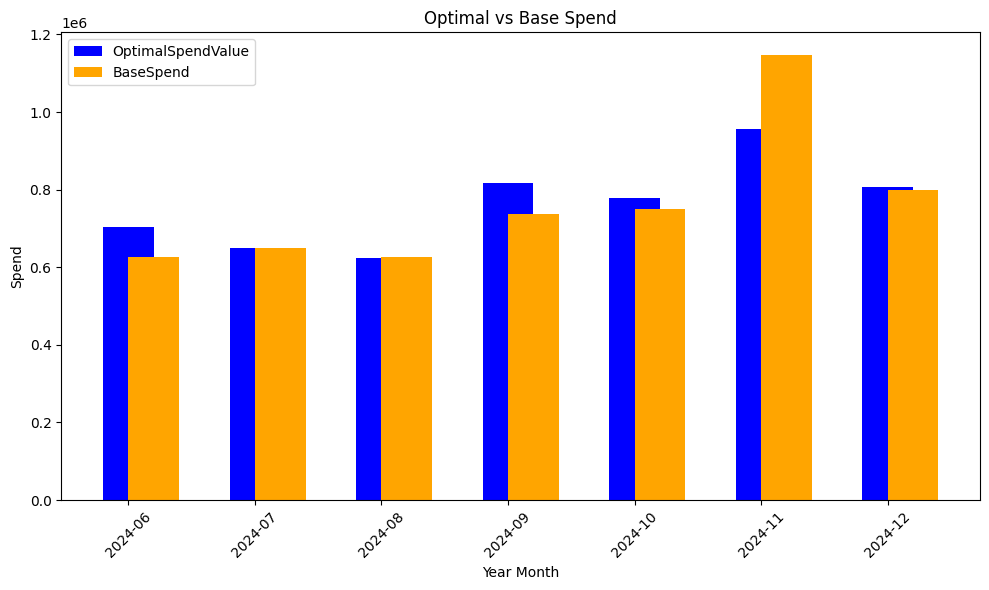

In [65]:

# Plot the bar graph
plt.figure(figsize=(10, 6))  # Set the size of the plot

# Plot OptimalConversionQuantity
plt.bar(forecast_by_month['year_month'], forecast_by_month['OptimalSpendValue'], color='blue', width=0.4, label='OptimalSpendValue', align='center')

# Plot BaseConversionQuantity
plt.bar(forecast_by_month['year_month'], forecast_by_month['BaseSpend'], color='orange', width=0.4, label='BaseSpend', align='edge')

plt.xlabel('Year Month')
plt.ylabel('Spend')
plt.title('Optimal vs Base Spend')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

# Show the plot
plt.show()

2024-05-23 17:02:06,943 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:02:06,948 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:02:06,962 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


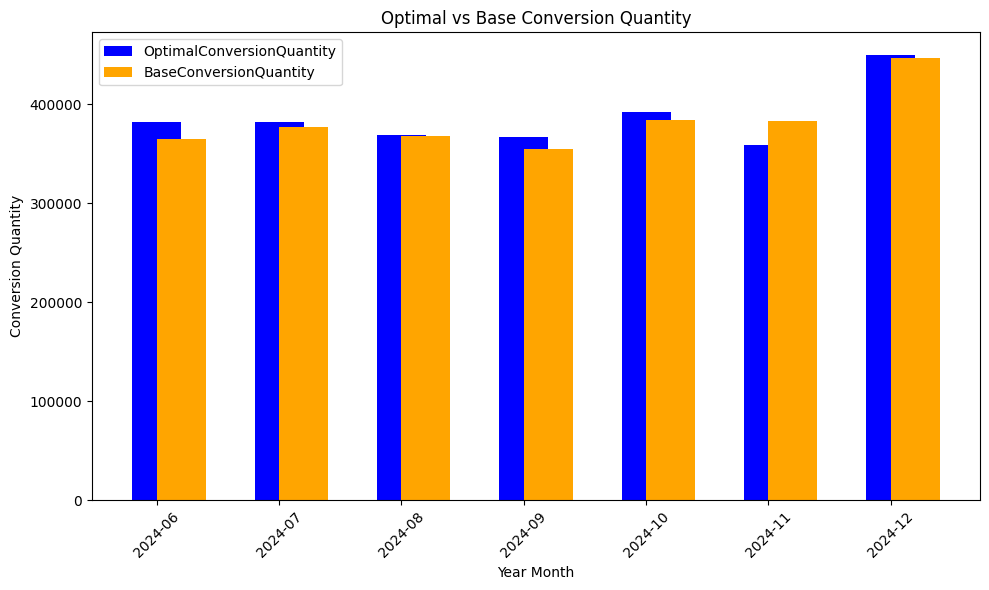

In [39]:
# Plot the bar graph
plt.figure(figsize=(10, 6))  # Set the size of the plot

# Plot OptimalConversionQuantity
plt.bar(forecast_by_month['year_month'], forecast_by_month['OptimalConversionQuantity'], color='blue', width=0.4, label='OptimalConversionQuantity', align='center')

# Plot BaseConversionQuantity
plt.bar(forecast_by_month['year_month'], forecast_by_month['BaseConversionQuantity'], color='orange', width=0.4, label='BaseConversionQuantity', align='edge')

plt.xlabel('Year Month')
plt.ylabel('Conversion Quantity')
plt.title('Optimal vs Base Conversion Quantity')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

# Show the plot
plt.show()

2024-05-23 17:25:13,279 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:25:13,302 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:25:13,315 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:25:13,348 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:25:13,

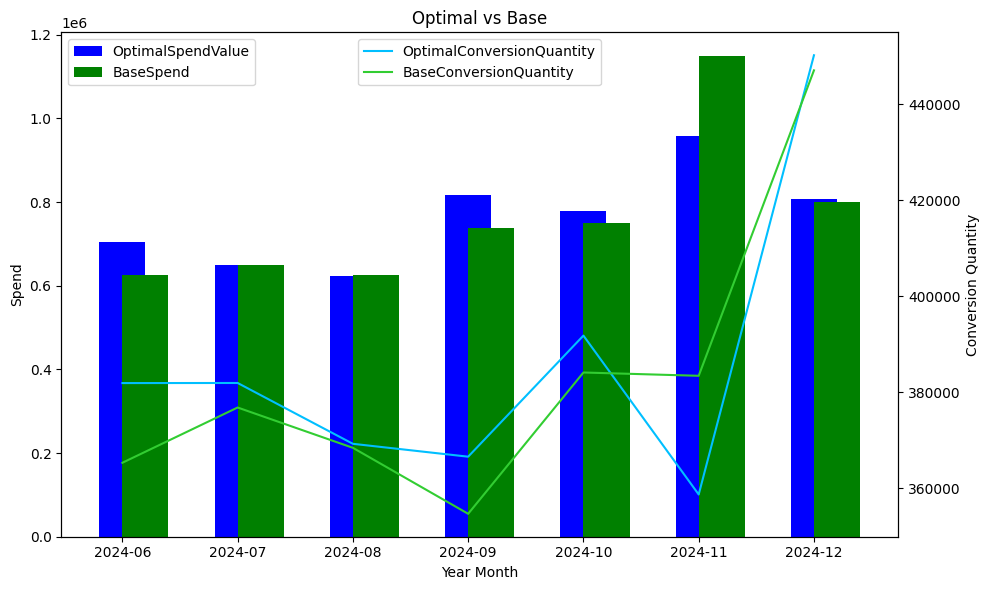

In [56]:
# Plot the bar graph
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot OptimalConversionQuantity
ax1.bar(forecast_by_month['year_month'], forecast_by_month['OptimalSpendValue'], color='blue', width=0.4, label='OptimalSpendValue', align='center')
# Plot BaseConversionQuantity
ax1.bar(forecast_by_month['year_month'], forecast_by_month['BaseSpend'], color='g', width=0.4, label='BaseSpend', align='edge')
ax1.set_ylabel('Spend')
ax1.set_xlabel('Year Month')
ax1.set_title('Optimal vs Base')
ax1.legend(loc='upper left')


ax2 = ax1.twinx()
ax2.plot(forecast_by_month['year_month'], forecast_by_month['OptimalConversionQuantity'], color='deepskyblue', label='OptimalConversionQuantity')
ax2.plot(forecast_by_month['year_month'], forecast_by_month['BaseConversionQuantity'], color='limegreen', label='BaseConversionQuantity')
ax2.set_ylabel('Conversion Quantity')
ax2.legend(loc='upper center')
ax2.tick_params(axis='y')

fig.tight_layout()

# Show the plot
plt.show()

In [57]:
Bing_Brand = forecast_by_split.loc[(forecast_by_split['Account_type']=='Bing Ads')&(forecast_by_split['Funnel']=='Brand')]
Bing_Generic = forecast_by_split.loc[(forecast_by_split['Account_type']=='Bing Ads')&(forecast_by_split['Funnel']=='Generic')]
Bing_Competitor = forecast_by_split.loc[(forecast_by_split['Account_type']=='Bing Ads')&(forecast_by_split['Funnel']=='Competitor')]
Google_Brand = forecast_by_split.loc[(forecast_by_split['Account_type']=='Google AdWords')&(forecast_by_split['Funnel']=='Brand')]
Google_Generic = forecast_by_split.loc[(forecast_by_split['Account_type']=='Google AdWords')&(forecast_by_split['Funnel']=='Generic')]
Google_Competitor = forecast_by_split.loc[(forecast_by_split['Account_type']=='Google AdWords')&(forecast_by_split['Funnel']=='Competitor')]

2024-05-23 17:28:00,728 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:28:00,731 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:28:00,742 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:28:00,770 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:28:00,

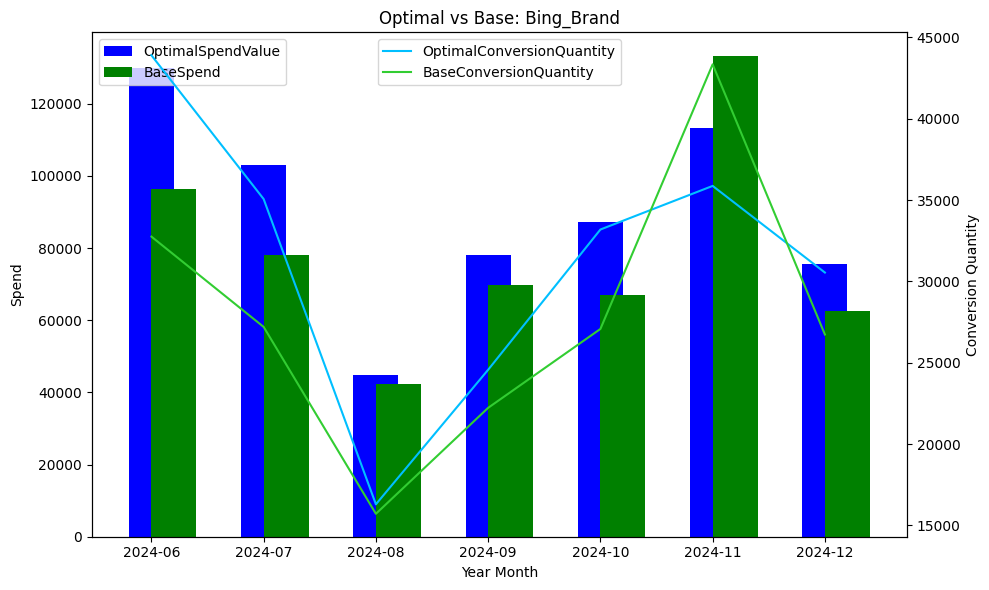

In [58]:
# Plot the bar graph
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot OptimalConversionQuantity
ax1.bar(Bing_Brand['year_month'], Bing_Brand['OptimalSpendValue'], color='blue', width=0.4, label='OptimalSpendValue', align='center')
# Plot BaseConversionQuantity
ax1.bar(Bing_Brand['year_month'], Bing_Brand['BaseSpend'], color='g', width=0.4, label='BaseSpend', align='edge')
ax1.set_ylabel('Spend')
ax1.set_xlabel('Year Month')
ax1.set_title('Optimal vs Base: Bing_Brand')
ax1.legend(loc='upper left')


ax2 = ax1.twinx()
ax2.plot(Bing_Brand['year_month'], Bing_Brand['OptimalConversionQuantity'], color='deepskyblue', label='OptimalConversionQuantity')
ax2.plot(Bing_Brand['year_month'], Bing_Brand['BaseConversionQuantity'], color='limegreen', label='BaseConversionQuantity')
ax2.set_ylabel('Conversion Quantity')
ax2.legend(loc='upper center')
ax2.tick_params(axis='y')

fig.tight_layout()

# Show the plot
plt.show()

2024-05-23 17:28:06,185 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:28:06,189 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:28:06,208 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:28:06,236 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:28:06,

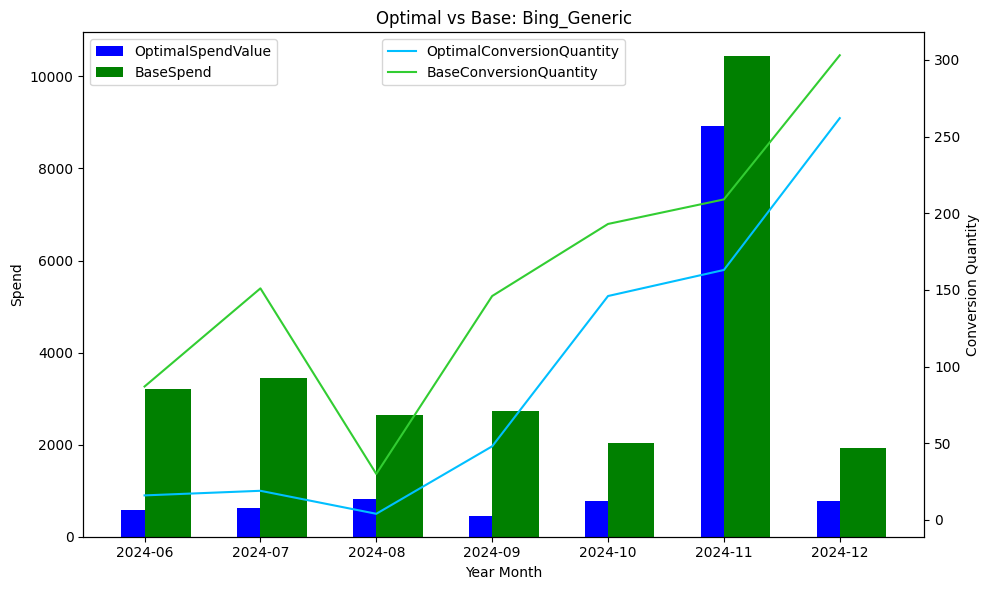

In [59]:
# Plot the bar graph
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot OptimalConversionQuantity
ax1.bar(Bing_Generic['year_month'], Bing_Generic['OptimalSpendValue'], color='blue', width=0.4, label='OptimalSpendValue', align='center')
# Plot BaseConversionQuantity
ax1.bar(Bing_Generic['year_month'], Bing_Generic['BaseSpend'], color='g', width=0.4, label='BaseSpend', align='edge')
ax1.set_ylabel('Spend')
ax1.set_xlabel('Year Month')
ax1.set_title('Optimal vs Base: Bing_Generic')
ax1.legend(loc='upper left')


ax2 = ax1.twinx()
ax2.plot(Bing_Generic['year_month'], Bing_Generic['OptimalConversionQuantity'], color='deepskyblue', label='OptimalConversionQuantity')
ax2.plot(Bing_Generic['year_month'], Bing_Generic['BaseConversionQuantity'], color='limegreen', label='BaseConversionQuantity')
ax2.set_ylabel('Conversion Quantity')
ax2.legend(loc='upper center')
ax2.tick_params(axis='y')

fig.tight_layout()

# Show the plot
plt.show()

2024-05-23 17:28:09,896 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:28:09,900 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:28:09,914 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:28:09,949 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:28:09,

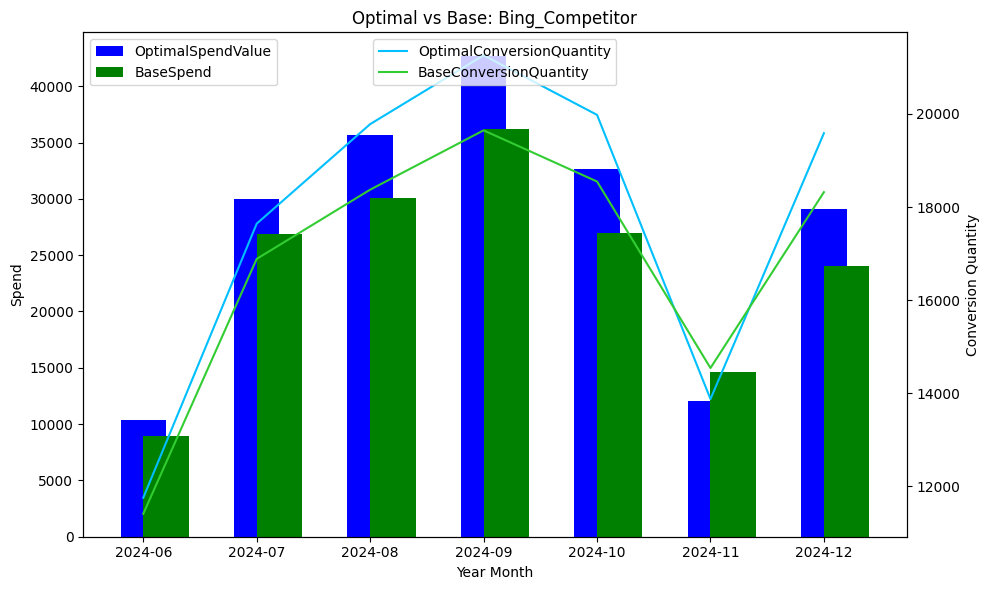

In [60]:
# Plot the bar graph
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot OptimalConversionQuantity
ax1.bar(Bing_Competitor['year_month'], Bing_Competitor['OptimalSpendValue'], color='blue', width=0.4, label='OptimalSpendValue', align='center')
# Plot BaseConversionQuantity
ax1.bar(Bing_Competitor['year_month'], Bing_Competitor['BaseSpend'], color='g', width=0.4, label='BaseSpend', align='edge')
ax1.set_ylabel('Spend')
ax1.set_xlabel('Year Month')
ax1.set_title('Optimal vs Base: Bing_Competitor')
ax1.legend(loc='upper left')


ax2 = ax1.twinx()
ax2.plot(Bing_Competitor['year_month'], Bing_Competitor['OptimalConversionQuantity'], color='deepskyblue', label='OptimalConversionQuantity')
ax2.plot(Bing_Competitor['year_month'], Bing_Competitor['BaseConversionQuantity'], color='limegreen', label='BaseConversionQuantity')
ax2.set_ylabel('Conversion Quantity')
ax2.legend(loc='upper center')
ax2.tick_params(axis='y')

fig.tight_layout()

# Show the plot
plt.show()

2024-05-23 17:28:14,037 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:28:14,040 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:28:14,050 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:28:14,075 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:28:14,

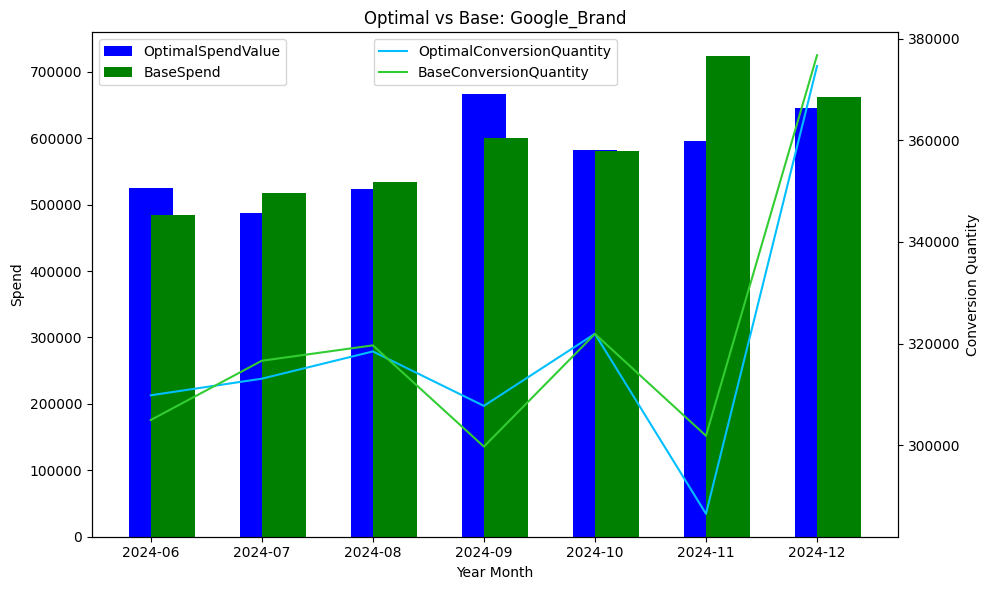

In [61]:
# Plot the bar graph
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot OptimalConversionQuantity
ax1.bar(Google_Brand['year_month'], Google_Brand['OptimalSpendValue'], color='blue', width=0.4, label='OptimalSpendValue', align='center')
# Plot BaseConversionQuantity
ax1.bar(Google_Brand['year_month'], Google_Brand['BaseSpend'], color='g', width=0.4, label='BaseSpend', align='edge')
ax1.set_ylabel('Spend')
ax1.set_xlabel('Year Month')
ax1.set_title('Optimal vs Base: Google_Brand')
ax1.legend(loc='upper left')


ax2 = ax1.twinx()
ax2.plot(Google_Brand['year_month'], Google_Brand['OptimalConversionQuantity'], color='deepskyblue', label='OptimalConversionQuantity')
ax2.plot(Google_Brand['year_month'], Google_Brand['BaseConversionQuantity'], color='limegreen', label='BaseConversionQuantity')
ax2.set_ylabel('Conversion Quantity')
ax2.legend(loc='upper center')
ax2.tick_params(axis='y')

fig.tight_layout()

# Show the plot
plt.show()

2024-05-23 17:28:16,216 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:28:16,220 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:28:16,230 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:28:16,267 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:28:16,

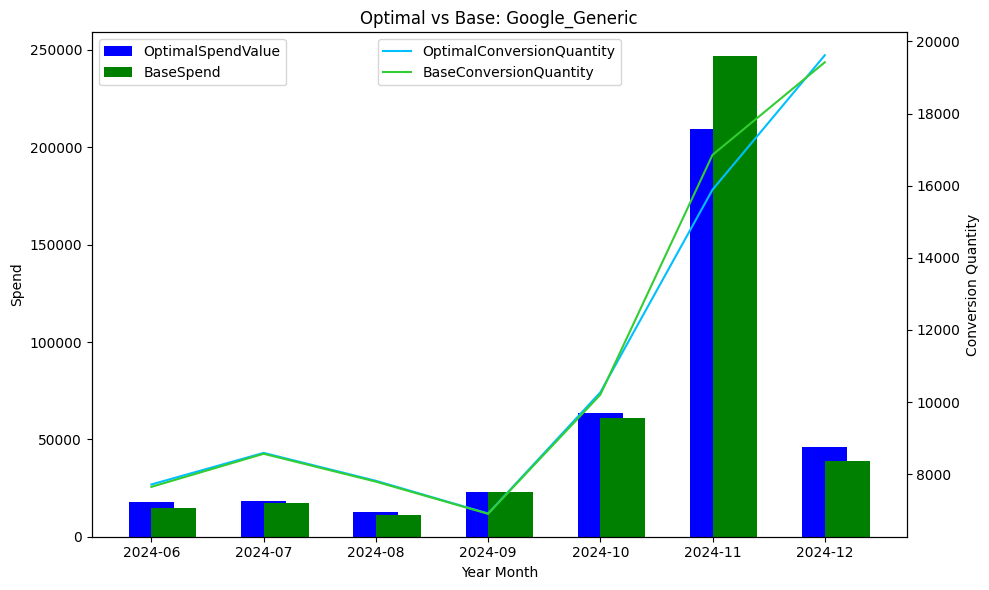

In [62]:
# Plot the bar graph
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot OptimalConversionQuantity
ax1.bar(Google_Generic['year_month'], Google_Generic['OptimalSpendValue'], color='blue', width=0.4, label='OptimalSpendValue', align='center')
# Plot BaseConversionQuantity
ax1.bar(Google_Generic['year_month'], Google_Generic['BaseSpend'], color='g', width=0.4, label='BaseSpend', align='edge')
ax1.set_ylabel('Spend')
ax1.set_xlabel('Year Month')
ax1.set_title('Optimal vs Base: Google_Generic')
ax1.legend(loc='upper left')


ax2 = ax1.twinx()
ax2.plot(Google_Generic['year_month'], Google_Generic['OptimalConversionQuantity'], color='deepskyblue', label='OptimalConversionQuantity')
ax2.plot(Google_Generic['year_month'], Google_Generic['BaseConversionQuantity'], color='limegreen', label='BaseConversionQuantity')
ax2.set_ylabel('Conversion Quantity')
ax2.legend(loc='upper center')
ax2.tick_params(axis='y')

fig.tight_layout()

# Show the plot
plt.show()

2024-05-23 17:28:19,680 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:28:19,683 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:28:19,692 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:28:19,715 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-23 17:28:19,

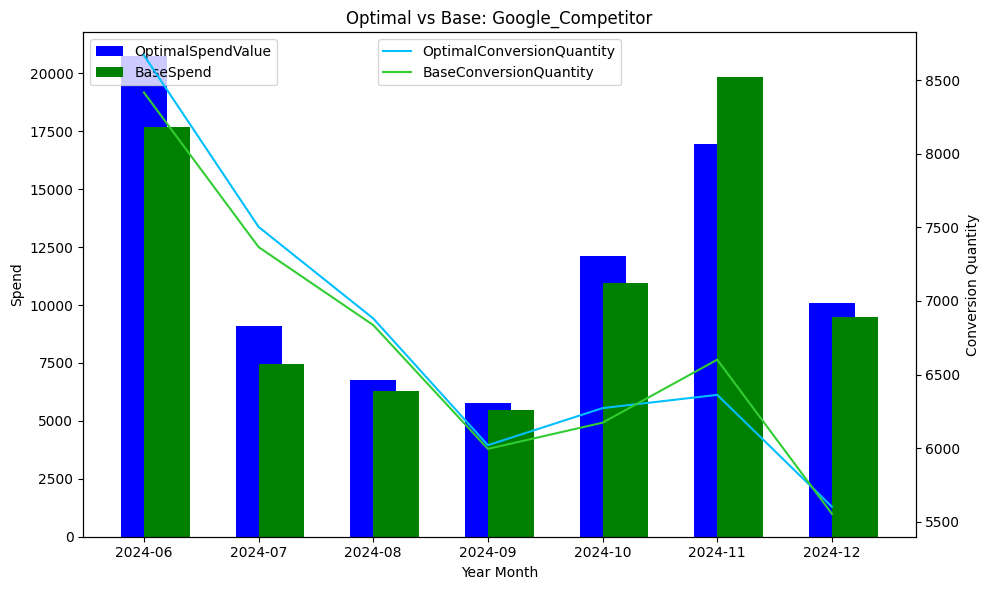

In [63]:
# Plot the bar graph
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot OptimalConversionQuantity
ax1.bar(Google_Competitor['year_month'], Google_Competitor['OptimalSpendValue'], color='blue', width=0.4, label='OptimalSpendValue', align='center')
# Plot BaseConversionQuantity
ax1.bar(Google_Competitor['year_month'], Google_Competitor['BaseSpend'], color='g', width=0.4, label='BaseSpend', align='edge')
ax1.set_ylabel('Spend')
ax1.set_xlabel('Year Month')
ax1.set_title('Optimal vs Base: Google_Competitor')
ax1.legend(loc='upper left')


ax2 = ax1.twinx()
ax2.plot(Google_Competitor['year_month'], Google_Competitor['OptimalConversionQuantity'], color='deepskyblue', label='OptimalConversionQuantity')
ax2.plot(Google_Competitor['year_month'], Google_Competitor['BaseConversionQuantity'], color='limegreen', label='BaseConversionQuantity')
ax2.set_ylabel('Conversion Quantity')
ax2.legend(loc='upper center')
ax2.tick_params(axis='y')

fig.tight_layout()

# Show the plot
plt.show()